Import des librairies nécessaire au bon fonctionnement du projet

In [1]:
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tarfile
from os import path
from tensorflow.keras import layers
from tensorflow import keras
import python_splitter
import shutil
from tensorflow.keras.models import load_model

import zipfile
from PIL import Image
from bs4 import BeautifulSoup

from PIL import Image
import cv2
from tensorflow.keras.models import Model
from keras import callbacks

import shutil
import numpy as np

Activation de l'utilisation du GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Téléchargement du dataset

In [3]:
if not path.isdir('dataset'):
    data_dir = tf.keras.utils.get_file(
        "dataset.tar",
        "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar",
        extract=False)
    with tarfile.open(data_dir, 'r') as tar_ref:
        tar_ref.extractall(path='/data/dataset/')
    print('Dataset installé')
else:
    print('Dataset déja installé')

Dataset déja installé


Import d'annotation concernant les images du dataset

In [4]:
if not path.isdir('annotation'):
    data_dir = tf.keras.utils.get_file(
        "annotation.tar",
        "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar",
        extract=False)
    with tarfile.open(data_dir, 'r') as tar_ref:
        tar_ref.extractall(path='/data/annotation/')
    print('Dataset installé')
else:
    print('Dataset déja installé')

Dataset déja installé


Première phase de prétraitement qui consiste à isoler les chiens dans les images afin de limiter les informations superflu

In [5]:
if path.isdir('custom_dataset'):
    shutil.rmtree("custom_dataset")
os.mkdir('custom_dataset')
os.mkdir('custom_dataset/Images')

directories = os.listdir('annotation/Annotation')
for directory in directories:
    os.mkdir('custom_dataset/Images/' + directory)
    files = os.listdir('annotation/Annotation/' + directory)
    for file in files:
        old_name = 'annotation/Annotation/' + directory + '/' + file
        new_name = 'annotation/Annotation/' + directory + '/' + file + '.xml'
        os.rename(old_name, new_name)
        if path.exists("dataset/Images/" + directory + '/' + file + '.jpg'):
            with open(new_name, 'r') as f:
                data = f.read()
            Bs_data = BeautifulSoup(data, "xml")
            boxes = Bs_data.find('xmin')
            for i in range(len(boxes)):
                xmin = int(str(Bs_data.find_all('xmin')[i]).replace('<xmin>', '').replace('</xmin>', ''))
                ymin = int(str(Bs_data.find_all('ymin')[i]).replace('<ymin>', '').replace('</ymin>', ''))
                xmax = int(str(Bs_data.find_all('xmax')[i]).replace('<xmax>', '').replace('</xmax>', ''))
                ymax = int(str(Bs_data.find_all('ymax')[i]).replace('<ymax>', '').replace('</ymax>', ''))
                image = Image.open(r"dataset/Images/" + directory + "/" + file + ".jpg")
                image = image.convert('RGB')
                image = image.crop((xmin, ymin, xmax, ymax))
                image.save("custom_dataset/Images/" + directory + "/" + file + ".jpg")
        os.rename(new_name, old_name)

Séparation du dataset en données d'entrainement, validation et test
python_splitter.split_from_folder a un bug et inverse le répertoire de test et de val donc il faut inverser les valeurs (voir pour changer la façon de split)

In [6]:
if path.isdir('Train_Test_Folder'):
    shutil.rmtree("Train_Test_Folder")
python_splitter.split_from_folder("/data/custom_dataset/Images", train = 0.7, test = 0.25)

✅Checking SOURCE directory...
0.7 0 0.25
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


Création d'un tableau contenant toutes les races

In [7]:
items = os.listdir('custom_dataset/Images')
items.sort()
dog_categories = [];
for item in items:
    dog_categories.append(item.split('-')[1])

Import des batch d'images et redimensionnement

Found 14355 files belonging to 120 classes.
Found 1077 files belonging to 120 classes.
Found 5148 files belonging to 120 classes.


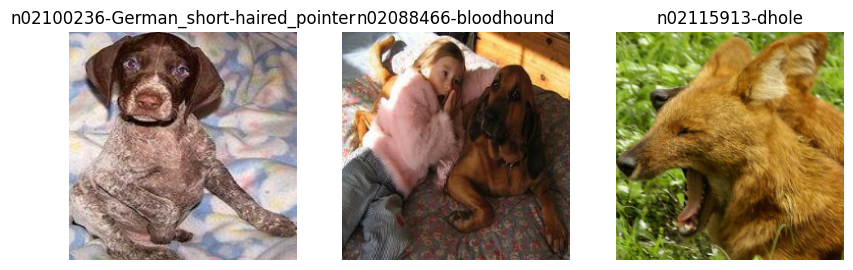

In [8]:
BATCH_SIZE = 32
IMG_SIZE = 224
NB_CLASS = 120
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/train'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/test'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path('Train_Test_Folder/val'),
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Je transforme mes classes en un vecteur one hot

In [10]:
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=NB_CLASS)))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Seconde couche de prétraitement qui permet d'augmenter de manière artificielle le nombre de données d'entrainement

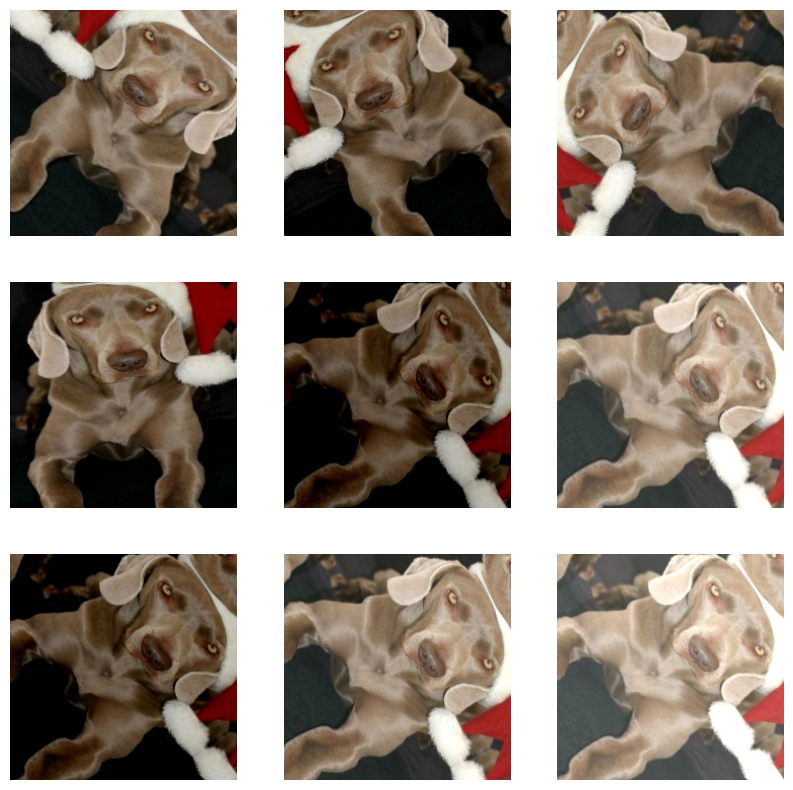

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(0.3)
])

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Import de la deapfeature ResNet101V2 préentrainé sur les poids d'imagenet

In [12]:
base_model = keras.applications.ResNet101V2(
    include_top=False, # Exclude ImageNet classifier at the top
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

171317808/171317808 [==============================] - 10s 0us/step


base_model.trainable = FalseJe gèle les poids pour qu'ils ne soient pas mis à jour durant l'entrainement du réseau

In [13]:
base_model.trainable = False

Contruction du modèle 

In [14]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

Je met une couche de normalisation afin que toute mes images aient le même niveau de flou

In [15]:
layers.GaussianNoise(stddev=0.2)(x)

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'gaussian_noise')>

J'intégre ma deapfeature

In [16]:
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)

J'ajoute les couches permettant la classifications des races de chiens

In [17]:
x = layers.GlobalAveragePooling2D()(x) # Average pooling operation
x = layers.BatchNormalization()(x) # Introduce batch norm
x = layers.Dropout(0.8)(x)  # Regularize with dropout
outputs = layers.Dense(NB_CLASS, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

Je compile mon modèle 

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

Je met en place un métrique d'early stopping afin d'éviter le sur apprentissage
Si la fonction de perte sur mes données d'entrainement ne diminu pas significativement pendant 5 époques alors j'arrête l'entrainement et je restore les meilleurs poids pour le réseau

In [19]:
earlystopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=5, 
    restore_best_weights=True,
    min_delta = 0.01
)

Définition d'une nouvelle métrique permettant d'obtenir la précision du modèle pour chacune des races

In [20]:
class Metrics(keras.callbacks.Callback):
    def __init__(self, val_data, dog_categories):
        super().__init__()
        self.validation_data = val_data
    def on_train_begin(self, logs={}):
        self._data = {}
        for dog_category in dog_categories:
                self._data[dog_category] = {
                        'vrai positif': 0,
                        'faux positif': 0,
                        'precision':0
                    }

    def on_epoch_end(self, batch, logs={}):
        for x_test, y_test in self.validation_data:
            y_predict = np.asarray(model.predict(x_test, verbose=0))

            true = np.argmax(y_test, axis=1)
            pred = np.argmax(y_predict, axis=1)
            predictions = zip(true, pred);
            for test, prediction in predictions:
                if test == prediction:
                    self._data[dog_categories[test]]['vrai positif'] = self._data[dog_categories[test]]['vrai positif'] + 1
                if test != prediction:
                    self._data[dog_categories[prediction]]['faux positif'] = self._data[dog_categories[prediction]]['faux positif'] + 1
        return

    def get_data(self):
        for data in self._data:
            self._data[data]['precision'] = self._data[data]['vrai positif'] / (self._data[data]['vrai positif'] + self._data[data]['faux positif'])
        return self._data
    
metrics = Metrics(val_data = validation_dataset, dog_categories = dog_categories)

Début de l'entrainement du modèle sur 25 époques

In [21]:
EPOCHS = 25

history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    validation_data=validation_dataset, 
    verbose=1,
    callbacks =[earlystopping, metrics]
)

Epoch 1/25
449/449 [==============================] - 325s 705ms/step - loss: 3.9235 - categorical_accuracy: 0.2708 - val_loss: 0.6890 - val_categorical_accuracy: 0.7898
Epoch 2/25
449/449 [==============================] - 311s 693ms/step - loss: 2.3893 - categorical_accuracy: 0.4831 - val_loss: 0.5977 - val_categorical_accuracy: 0.8079
Epoch 3/25
449/449 [==============================] - 312s 694ms/step - loss: 2.0978 - categorical_accuracy: 0.5382 - val_loss: 0.5843 - val_categorical_accuracy: 0.8162
Epoch 4/25
449/449 [==============================] - 309s 687ms/step - loss: 2.0255 - categorical_accuracy: 0.5512 - val_loss: 0.5630 - val_categorical_accuracy: 0.8263
Epoch 5/25
449/449 [==============================] - 307s 683ms/step - loss: 1.9898 - categorical_accuracy: 0.5587 - val_loss: 0.5598 - val_categorical_accuracy: 0.8283
Epoch 6/25
449/449 [==============================] - 318s 708ms/step - loss: 1.9007 - categorical_accuracy: 0.5781 - val_loss: 0.5470 - val_categoric

Affichage de la précision pour chacune des races

In [22]:
metrics.get_data()

{'Chihuahua': {'vrai positif': 743,
  'faux positif': 113,
  'precision': 0.8679906542056075},
 'Japanese_spaniel': {'vrai positif': 1012,
  'faux positif': 201,
  'precision': 0.8342951360263808},
 'Maltese_dog': {'vrai positif': 1362,
  'faux positif': 242,
  'precision': 0.8491271820448878},
 'Pekinese': {'vrai positif': 769,
  'faux positif': 134,
  'precision': 0.8516057585825028},
 'Shih': {'vrai positif': 950,
  'faux positif': 294,
  'precision': 0.7636655948553055},
 'Blenheim_spaniel': {'vrai positif': 1042,
  'faux positif': 108,
  'precision': 0.9060869565217391},
 'papillon': {'vrai positif': 1148,
  'faux positif': 80,
  'precision': 0.9348534201954397},
 'toy_terrier': {'vrai positif': 799,
  'faux positif': 151,
  'precision': 0.8410526315789474},
 'Rhodesian_ridgeback': {'vrai positif': 797,
  'faux positif': 340,
  'precision': 0.7009674582233949},
 'Afghan_hound': {'vrai positif': 1342,
  'faux positif': 44,
  'precision': 0.9682539682539683},
 'basset': {'vrai posit

Evaluation du modèle sur les données de test

In [23]:
model.evaluate(test_dataset)

34/34 [==============================] - 6s 180ms/step - loss: 0.3931 - categorical_accuracy: 0.8654


[0.39309847354888916, 0.8653667569160461]

Coubes permettant de voir l'évolution de l'entrainement

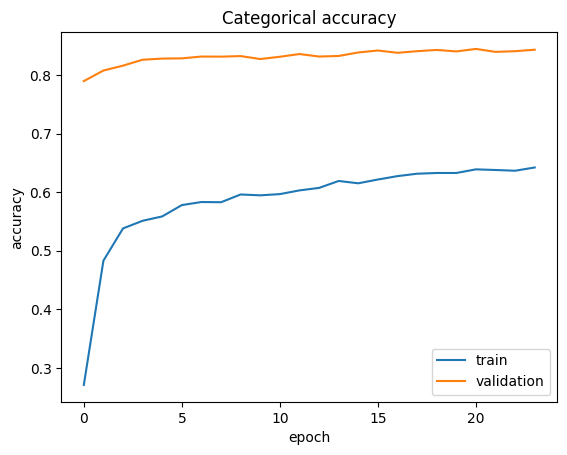

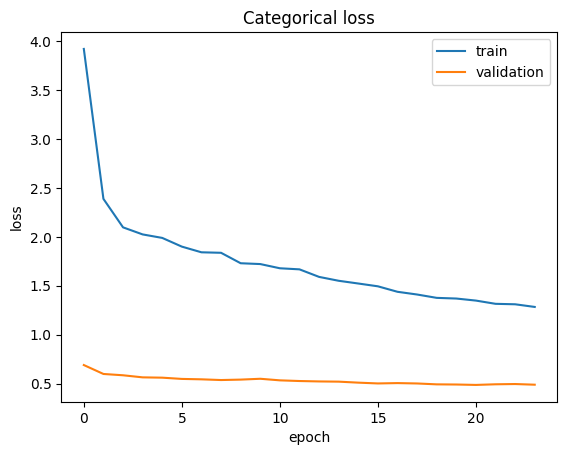

In [24]:
def plot_accuracy(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Categorical loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

plot_accuracy(history)
plot_loss(history)

Maintenant on passe au fine tunning du modèle

Nombre de variable de base entrainable par le modèle

In [42]:
len(model.trainable_variables)
print(len(model.variables))
print(len(model.trainable_variables))
print(len(base_model.variables))
print(len(base_model.trainable_variables))
print("Number of layers in the base model: ", len(base_model.layers))

548
346
542
342
Number of layers in the base model:  377


On fait passer les 15 dernières couches en entrainable, le nombre de variable augmente

In [26]:
for layer in model.layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
        
len(model.trainable_variables)

346

On recompile le modèle avec ces nouveaux paramètre et on met un ratio d'apprentissage faible pour éviter le sur apprentissage

In [27]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0000075),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

on diminue le nombre d'époque dans un même soucis de sur apprentissage

In [28]:
EPOCHS = history.epoch[-1] + 5

history_finetunning = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset, 
    verbose=1,
    callbacks =[metrics]
)

Epoch 24/28


2023-03-12 02:36:51.371734: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-12 02:36:51.372064: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-12 02:36:51.401561: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-12 02:36:51.401597: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

449/449 [==============================] - 500s 1s/step - loss: 1.2820 - categorical_accuracy: 0.6571 - val_loss: 0.5292 - val_categorical_accuracy: 0.8380
Epoch 25/28
449/449 [==============================] - 461s 1s/step - loss: 1.1451 - categorical_accuracy: 0.6820 - val_loss: 0.5223 - val_categorical_accuracy: 0.8380
Epoch 26/28
449/449 [==============================] - 462s 1s/step - loss: 1.0989 - categorical_accuracy: 0.6935 - val_loss: 0.5506 - val_categorical_accuracy: 0.8326
Epoch 27/28
449/449 [==============================] - 463s 1s/step - loss: 1.0400 - categorical_accuracy: 0.7057 - val_loss: 0.5534 - val_categorical_accuracy: 0.8291
Epoch 28/28
449/449 [==============================] - 463s 1s/step - loss: 0.9828 - categorical_accuracy: 0.7161 - val_loss: 0.5281 - val_categorical_accuracy: 0.8405


On regarde la précision par races

In [29]:
metrics.get_data()

{'Chihuahua': {'vrai positif': 159,
  'faux positif': 43,
  'precision': 0.7871287128712872},
 'Japanese_spaniel': {'vrai positif': 212,
  'faux positif': 43,
  'precision': 0.8313725490196079},
 'Maltese_dog': {'vrai positif': 281,
  'faux positif': 43,
  'precision': 0.8672839506172839},
 'Pekinese': {'vrai positif': 156,
  'faux positif': 22,
  'precision': 0.8764044943820225},
 'Shih': {'vrai positif': 229,
  'faux positif': 77,
  'precision': 0.7483660130718954},
 'Blenheim_spaniel': {'vrai positif': 217,
  'faux positif': 16,
  'precision': 0.9313304721030042},
 'papillon': {'vrai positif': 239,
  'faux positif': 24,
  'precision': 0.908745247148289},
 'toy_terrier': {'vrai positif': 162,
  'faux positif': 30,
  'precision': 0.84375},
 'Rhodesian_ridgeback': {'vrai positif': 185,
  'faux positif': 93,
  'precision': 0.6654676258992805},
 'Afghan_hound': {'vrai positif': 283,
  'faux positif': 13,
  'precision': 0.956081081081081},
 'basset': {'vrai positif': 184,
  'faux positif'

On évalue le modèle

In [30]:
model.evaluate(test_dataset)

34/34 [==============================] - 5s 151ms/step - loss: 0.4055 - categorical_accuracy: 0.8728


[0.40546759963035583, 0.8727948069572449]

On affiche les courbes résultat du finetunning

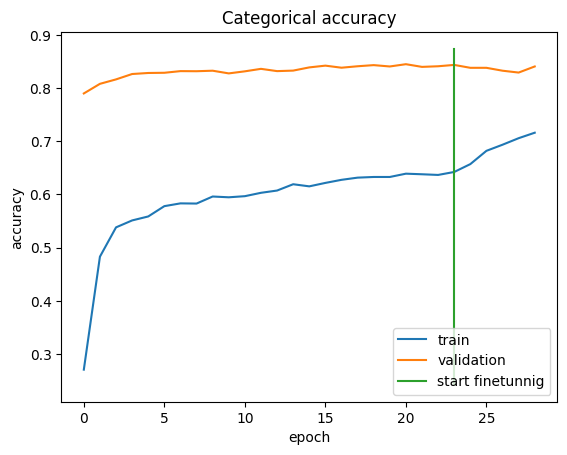

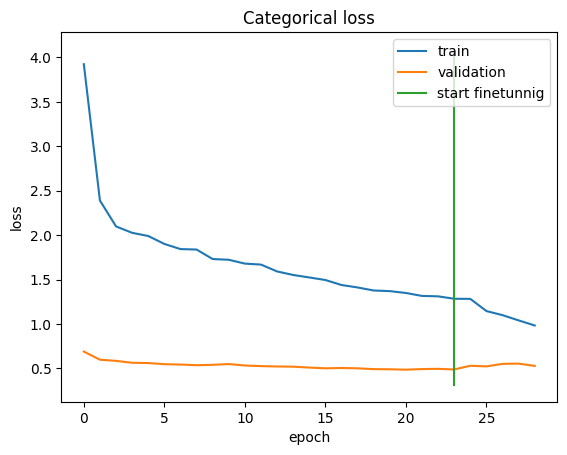

In [31]:
def plot_accuracy_fine(hist, hist_fine):
    train_histo = hist.history['categorical_accuracy'] + hist_fine.history['categorical_accuracy']
    validation_histo = hist.history['val_categorical_accuracy'] + hist_fine.history['val_categorical_accuracy']
    plt.plot(train_histo)
    plt.plot(validation_histo)
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.plot([history.epoch[-1],history.epoch[-1]],
          plt.ylim(), label='Start Fine Tuning')
    plt.legend(['train', 'validation', 'start finetunnig'], loc='lower right')
    plt.show()
    
def plot_loss_fine(hist, hist_fine):
    train_histo = hist.history['loss'] + hist_fine.history['loss']
    validation_histo = hist.history['val_loss'] + hist_fine.history['val_loss']
    plt.plot(train_histo)
    plt.plot(validation_histo)
    plt.title('Categorical loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.plot(
        [history.epoch[-1],history.epoch[-1]],
          plt.ylim(), label='Start Fine Tuning'
    )
    plt.legend(['train', 'validation', 'start finetunnig'], loc='upper right')
    plt.show()
    
plot_accuracy_fine(history, history_finetunning)
plot_loss_fine(history, history_finetunning)

On va maintenant chercher à voir comment le modèle visualise les images

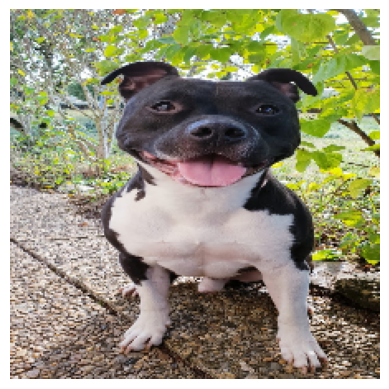

In [32]:
image = cv2.imread('tyson.jpg')
new_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
plt.axis('off')
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
plt.show()

On fait une prediction sur l'image

In [33]:
img = np.expand_dims(cv2.resize(image,(IMG_SIZE, IMG_SIZE)), axis=0)
y_predict = np.asarray(model.predict(img, verbose=0))
pred = np.argmax(y_predict, axis=1)
print(dog_categories[pred[0]])

American_Staffordshire_terrier


On affiche les détails du modèle

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

On visualise les filtres

1/1 [==============================] - 0s 37ms/step
56
conv2_block1_0_conv | Features Shape: (1, 56, 56, 256)
1/1 [==============================] - 0s 92ms/step
56
conv2_block2_1_conv | Features Shape: (1, 56, 56, 64)
1/1 [==============================] - 0s 148ms/step
28
conv3_block1_2_conv | Features Shape: (1, 28, 28, 128)
1/1 [==============================] - 0s 220ms/step
14
conv4_block1_0_conv | Features Shape: (1, 14, 14, 1024)
1/1 [==============================] - 0s 379ms/step
14
conv4_block5_2_conv | Features Shape: (1, 14, 14, 256)
1/1 [==============================] - 1s 801ms/step
7
conv5_block2_1_conv | Features Shape: (1, 7, 7, 512)


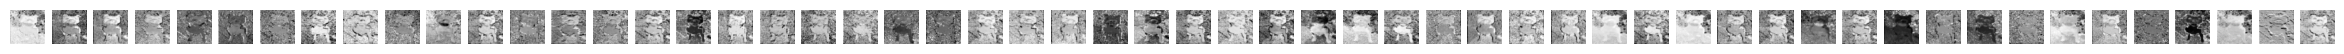

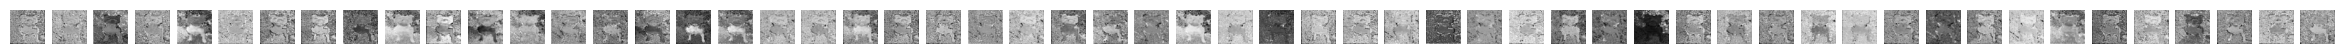

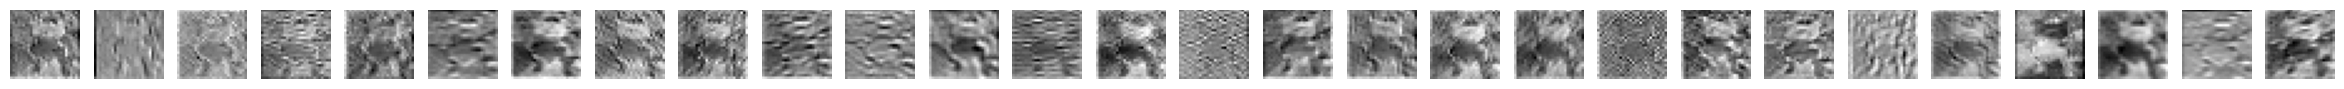

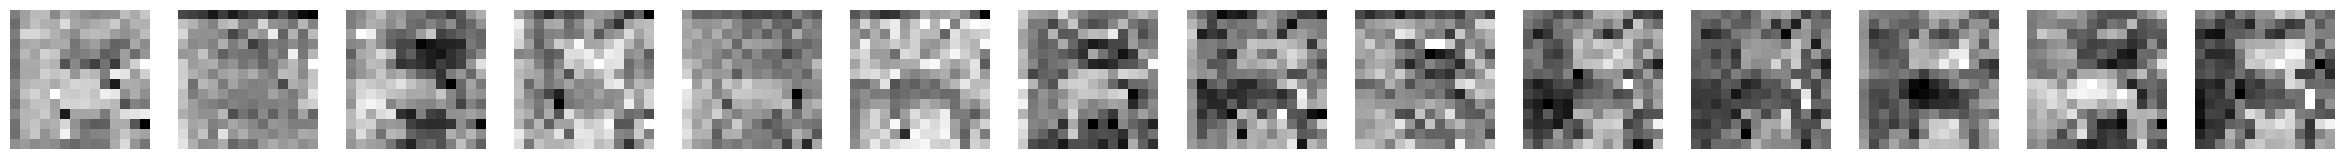

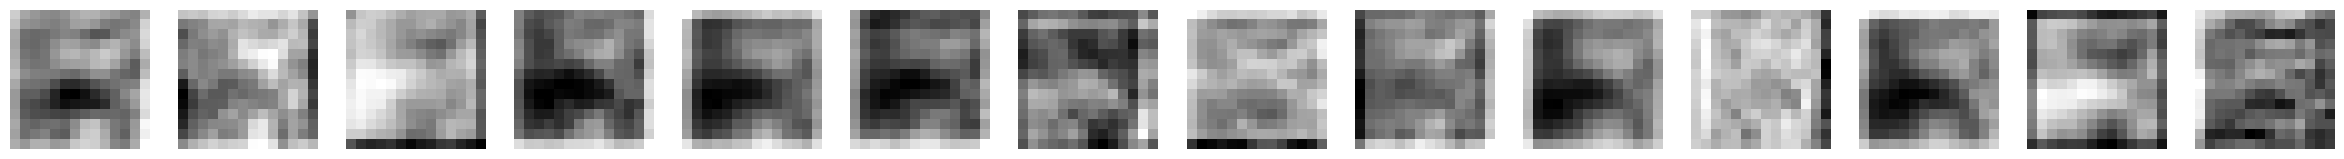

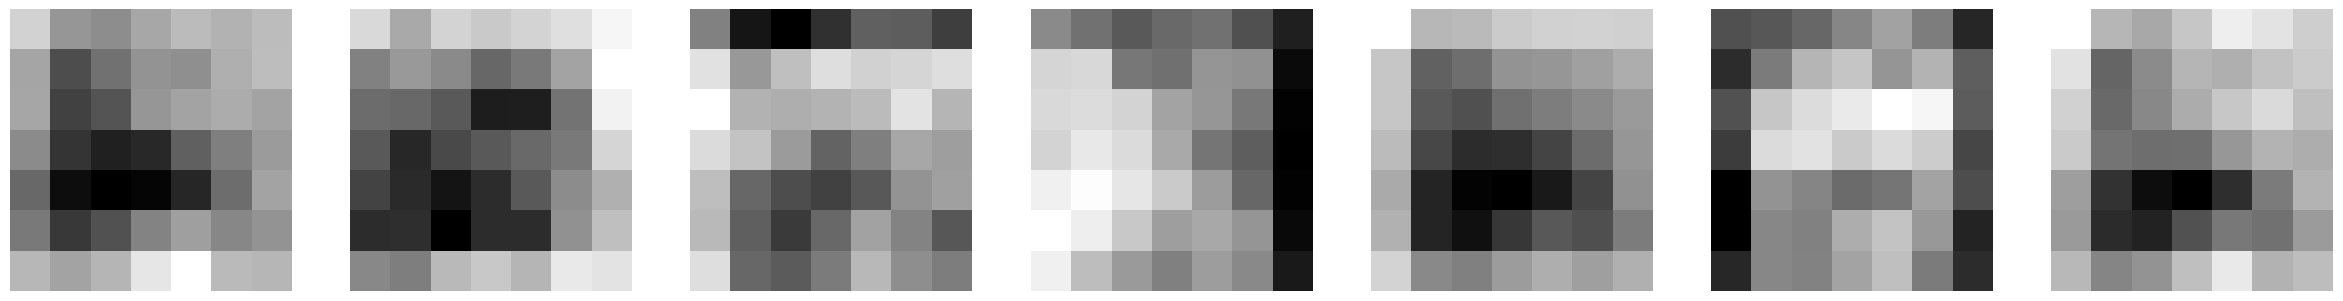

In [35]:
def display_image_filtered(name_image,model,layer_name,image):
    inp= model.inputs 
    out1= model.get_layer(layer_name).output  
    feature_map_1= Model(inputs= inp, outputs= out1)  
    img=cv2.resize(image,(IMG_SIZE,IMG_SIZE))              
    input_img= np.expand_dims(img, axis=0)      
    f=feature_map_1.predict(input_img) 
    dim = f.shape[1]
    print(dim)
    print(f'{layer_name} | Features Shape: {f.shape}')
    
    fig= plt.figure(figsize=(30,30))
    
    if not os.path.exists(f'results_{name_image}'):
        os.makedirs(f'results_{name_image}')        
    for i in range(dim):
        ax = fig.add_subplot(int(dim), int(dim),i+1)
        ax.axis('off')
        ax.imshow(f[0,:,:,i], cmap='gray')
        # plt.imsave(f'results_{name_image}/{name_image}_{layer_name}_{i}.jpg',f[0,:,:,i])
        
display_image_filtered('test', base_model, f'conv2_block1_0_conv', new_image)
display_image_filtered('test', base_model, f'conv2_block2_1_conv', new_image)  
display_image_filtered('test', base_model, f'conv3_block1_2_conv', new_image)  
display_image_filtered('test', base_model, f'conv4_block1_0_conv', new_image) 
display_image_filtered('test', base_model, f'conv4_block5_2_conv', new_image)  
display_image_filtered('test', base_model, f'conv5_block2_1_conv', new_image)

A faire : visualiser les features map optionnel

In [36]:
model.save('Modele_fine_v2.h5')